Let's first import some modules and load .env

In [21]:
import pandas as pd
import psycopg2
import dotenv
import os
import matplotlib.pyplot as plt
import numpy as np

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

and connect to the database

In [22]:
conn = psycopg2.connect(
    host="fuji.ucll.be",
    database="international_week",
    user=PG_USER,
    password=PG_PASSWORD,
    port=52425,
    sslmode="require",
)


Here, we define a function to count the number of actions. It takes three parameters: game_id (identifying the game), pov_team (a specific team in that game), and filter_sql (a filtering condition appended to the end of a complex query). In the function there is a complex query that retrieves the SPADL table, incorporating additional columns using Common Table Expressions (CTEs).

In [23]:

def count_actions(game_id, pov_team, conn, filter_sql):
    query = f"""
WITH action_changes AS (
        SELECT
            a.*,
            LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
            LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
        FROM
            public.spadl_actions a
        WHERE
            a.game_id = '{game_id}'
    ),
    possession_markers AS (
        SELECT
            *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
        FROM
            action_changes
    ),
    possession_groups AS (
        SELECT
            *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
        FROM
            possession_markers
    ),
    count_rows_in_possession_group AS (
        SELECT
            *,
            COUNT(*) OVER (PARTITION BY possession_group ORDER BY period_id, seconds, id) AS rows_in_possession_group
        FROM
            possession_groups
    ),
    initial_value_per_group AS (
        SELECT
            possession_group,
            MIN(seconds) AS initial_seconds
        FROM
            count_rows_in_possession_group
        GROUP BY
            possession_group
    ),
    possession_stats AS (
        SELECT
            possession_group,
            team_id,
            COUNT(*) AS action_count,
            MAX(id) AS last_action_id
        FROM
            count_rows_in_possession_group
        GROUP BY
            possession_group, team_id
    ),
    seconds_difference AS (
        SELECT
            c.*, 
            (c.seconds - i.initial_seconds) AS seconds_difference,
            ABS(c.start_x - c.end_x) AS action_distance
        FROM
            count_rows_in_possession_group c
        JOIN 
            initial_value_per_group i
        ON 
            c.possession_group = i.possession_group
    ),
    filters AS (
        SELECT *
        FROM seconds_difference
        WHERE team_id = '{pov_team}'
        AND possession_group IN (
            SELECT possession_group FROM possession_stats WHERE action_count >= 3
        )
    ),
    start_with_ball_table AS (
        SELECT *,
            CASE 
                WHEN FIRST_VALUE(prev_team_id) OVER (ORDER BY id) IS NULL AND FIRST_VALUE(end_x) OVER (ORDER BY id) < 52.5
                THEN 'LEFT_SIDE' 
                WHEN FIRST_VALUE(prev_team_id) OVER (ORDER BY id) IS NOT NULL AND FIRST_VALUE(end_x) OVER (ORDER BY id) < 52.5
                THEN 'RIGHT_SIDE'
                WHEN FIRST_VALUE(prev_team_id) OVER (ORDER BY id) IS NULL AND FIRST_VALUE(end_x) OVER (ORDER BY id) > 52.5
                THEN 'RIGHT_SIDE' 
                ELSE 'LEFT_SIDE' 
            END AS start_with_ball
        FROM filters
    ),
    start_with_period AS (
        SELECT *,
            CASE 
                WHEN start_with_ball = 'LEFT_SIDE' and period_id = 2
                THEN 'RIGHT_SIDE' 
                WHEN start_with_ball = 'RIGHT_SIDE' and period_id = 2
                THEN 'LEFT_SIDE' 
                WHEN start_with_ball = 'LEFT_SIDE' and period_id = 1
                THEN 'LEFT_SIDE' 
                WHEN start_with_ball = 'RIGHT_SIDE' and period_id = 1
                THEN 'RIGHT_SIDE' 
            END AS update_start_with_ball
        FROM start_with_ball_table
    ),
    direction AS (
        SELECT *,
            CASE 
            WHEN start_x > end_x AND update_start_with_ball = 'RIGHT_SIDE' THEN 'FORWARD'
            WHEN start_x < end_x AND update_start_with_ball = 'RIGHT_SIDE' THEN 'BACKWARD'
            WHEN start_x < end_x AND update_start_with_ball = 'LEFT_SIDE' THEN 'FORWARD'
            WHEN start_x > end_x AND update_start_with_ball = 'LEFT_SIDE' THEN 'BACKWARD'
            ELSE NULL
        END AS ballMoveDirection
        FROM start_with_period
    ),
	ballSidePositionAbsolute AS (
		select *,
		case
		when start_x >= 0 and start_x < 35 then 'LEFT_SIDE'
		when start_x >= 35 and start_x < 70 then 'MIDDLE'
		when start_x >= 70 and start_x < 105 then 'RIGHT_SIDE'
		else null
		end as actionStartSideAbsolute
		
		from direction
	),

	    ballSide AS (
        SELECT *,
            CASE 
                WHEN actionStartSideAbsolute = 'RIGHT_SIDE' AND update_start_with_ball = 'LEFT_SIDE' THEN '3'
                WHEN actionStartSideAbsolute = 'LEFT_SIDE' AND update_start_with_ball = 'RIGHT_SIDE' THEN '3'
                WHEN actionStartSideAbsolute = 'MIDDLE' THEN '2'
                WHEN actionStartSideAbsolute = 'RIGHT_SIDE' AND update_start_with_ball = 'RIGHT_SIDE' THEN '1'
                WHEN actionStartSideAbsolute = 'LEFT_SIDE' AND update_start_with_ball = 'LEFT_SIDE' THEN '1'
                ELSE NULL
            END AS possition_ball_by_action 
        FROM ballSidePositionAbsolute
    )
select count(*) from ballSide  {filter_sql}

    """
    return pd.read_sql_query(query, conn)



This function takes a query snippet as a parameter, which is appended to the previously mentioned complex query. It counts the actions of both teams in each match across all matches played and calculates the average number of those actions per match for all teams, based on the filtering conditions specified in the SQL snippet.

In [24]:
def count_average_actions_per_team(filter_sql):

    query_match = """
    SELECT 
        m.match_id, 
        m.home_team_id, 
        ht.team_name AS home_team_name, 
        m.away_team_id, 
        at.team_name AS away_team_name
    FROM public.matches m
    JOIN public.teams ht ON m.home_team_id = ht.team_id
    JOIN public.teams at ON m.away_team_id = at.team_id
    ORDER BY m.match_id ASC;
    """

    df = pd.read_sql_query(query_match, conn)

    team_stats = {}

    for row in df.itertuples(index=False):
        match_id, first_team_id, second_team_id, first_team_name, second_team_name = row.match_id, row.home_team_id, row.away_team_id, row.home_team_name, row.away_team_name

        first_actions = count_actions(match_id, first_team_id, conn, filter_sql) #we can reverse those lines if we want to have the for example all passes that the opposing team does
        second_actions = count_actions(match_id, second_team_id, conn, filter_sql) #but it's more for defencing actions.


        if first_team_name not in team_stats:
            team_stats[first_team_name] = {'total_actions': 0, 'match_count': 0}
        team_stats[first_team_name]['total_actions'] += first_actions
        team_stats[first_team_name]['match_count'] += 1

        if second_team_name not in team_stats:
            team_stats[second_team_name] = {'total_actions': 0, 'match_count': 0}
        team_stats[second_team_name]['total_actions'] += second_actions
        team_stats[second_team_name]['match_count'] += 1

    team_data = []
    for team_name, stats in team_stats.items():
        avg_actions = stats['total_actions'] / stats['match_count']
        team_data.append((team_name, avg_actions))

    average_df = pd.DataFrame(team_data, columns=['team_name', 'avg_actions'])

    average_df_copy = average_df.copy()

    average_df_copy['avg_actions'] = (
        average_df_copy['avg_actions']
        .astype(str)
        .str.replace(r'count\s*0\s*', '', regex=True)
        .str.strip()
        .replace('', '0')  
        .astype(float)  
    )

    return average_df_copy

Here, we define a query snippet to filter actions occurring within 10 seconds after a team gains possession through a forward pass. This snippet is then passed to the count_average_actions_per_team function, which calculates the average number of such passes for each team across all their matches. Finally, we display a DataFrame showing these averages for every team in the league.

In [7]:
filter_sql_forward = """WHERE seconds_difference <= 10 AND action_type IN ('0') AND ballMoveDirection = 'FORWARD'"""
df_filter_sql_forward = count_average_actions_per_team(filter_sql_forward)
df_filter_sql_forward

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\2932042939.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_match, conn)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\1726669913.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


,team_name,avg_actions
0,Club Brugge,124.947368
1,Mechelen,105.277778
2,Dender,98.000000
3,Union Saint-Gilloise,107.333333
4,Beerschot,94.176471
5,OH Leuven,90.611111
6,Anderlecht,100.000000
7,Sint-Truiden,105.944444
8,Genk,110.421053
9,Standard Liège,80.578947


Now, let's apply this for all forward passes made within 10 seconds after gaining possession, filtering them based on pass length: greater than 5m, 10m, and 20m.

In [8]:
filter_sql_forward_and_5m_distance = """WHERE seconds_difference <= 10 AND action_type IN ('0') AND ballMoveDirection = 'FORWARD' AND action_distance>5"""
df_filter_sql_forward_and_5m_distance = count_average_actions_per_team(filter_sql_forward_and_5m_distance)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\2932042939.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_match, conn)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\1726669913.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


In [9]:
filter_sql_forward_and_10m_distance = """WHERE seconds_difference <= 10 AND action_type IN ('0') AND ballMoveDirection = 'FORWARD' AND action_distance>10"""
df_filter_sql_forward_and_10m_distance = count_average_actions_per_team(filter_sql_forward_and_10m_distance)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\2932042939.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_match, conn)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\1726669913.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


In [10]:
filter_sql_forward_and_20m_distance = """WHERE seconds_difference <= 10 AND action_type IN ('0') AND ballMoveDirection = 'FORWARD' AND action_distance>20"""
df_filter_sql_forward_and_20m_distance = count_average_actions_per_team(filter_sql_forward_and_20m_distance)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\2932042939.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_match, conn)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\1726669913.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


In [11]:
df_merged = df_filter_sql_forward.merge(
    df_filter_sql_forward_and_5m_distance, on='team_name', suffixes=('_passes_forward', '_passes_forward_5m')
).merge(
    df_filter_sql_forward_and_10m_distance, on='team_name', suffixes=('', '_passes_forward_10m')
).merge(
    df_filter_sql_forward_and_20m_distance, on='team_name', suffixes=('', '_passes_forward_20m')
)

df_merged = df_merged.rename(columns={'avg_actions': 'avg_actions_passes_forward_10m'})

In [12]:
df_merged

,team_name,avg_actions_passes_forward,avg_actions_passes_forward_5m,avg_actions_passes_forward_10m,avg_actions_passes_forward_20m
0,Club Brugge,124.947368,89.315789,53.368421,17.105263
1,Mechelen,105.277778,75.611111,48.222222,15.611111
2,Dender,98.000000,73.333333,47.333333,18.444444
3,Union Saint-Gilloise,107.333333,77.166667,51.000000,18.722222
4,Beerschot,94.176471,66.823529,42.823529,14.529412
5,OH Leuven,90.611111,67.444444,43.444444,14.777778
6,Anderlecht,100.000000,70.157895,42.052632,13.947368
7,Sint-Truiden,105.944444,73.444444,45.333333,13.500000
8,Genk,110.421053,79.263158,47.157895,12.894737
9,Standard Liège,80.578947,56.631579,36.684211,12.947368


We can also add columns to display the ratios of forward passes longer than 5m, 10m, and 20m compared to the total number of forward passes.

In [13]:
df_merged['ratio 5m'] = df_merged['avg_actions_passes_forward_5m']/df_merged['avg_actions_passes_forward']
df_merged['ratio 10m'] = df_merged['avg_actions_passes_forward_10m']/df_merged['avg_actions_passes_forward']
df_merged['ratio 20m'] = df_merged['avg_actions_passes_forward_20m']/df_merged['avg_actions_passes_forward']
df_merged[['team_name','ratio 5m', 'ratio 10m', 'ratio 20m']]

,team_name,ratio 5m,ratio 10m,ratio 20m
0,Club Brugge,0.714827,0.427127,0.136900
1,Mechelen,0.718206,0.458047,0.148285
2,Dender,0.748299,0.482993,0.188209
3,Union Saint-Gilloise,0.718944,0.475155,0.174431
4,Beerschot,0.709557,0.454716,0.154279
5,OH Leuven,0.744329,0.479460,0.163090
6,Anderlecht,0.701579,0.420526,0.139474
7,Sint-Truiden,0.693235,0.427897,0.127425
8,Genk,0.717826,0.427073,0.116778
9,Standard Liège,0.702809,0.455258,0.160679


Now, let's visualize these ratios in a graph.

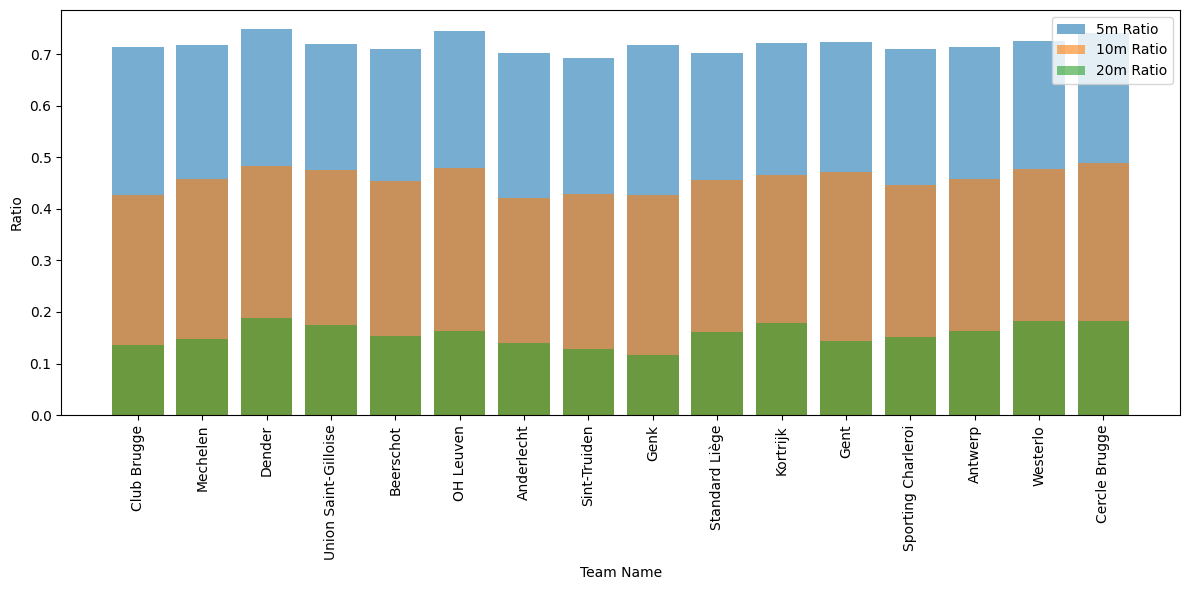

In [14]:
plt.figure(figsize=(12, 6))
plt.bar(df_merged['team_name'], df_merged['ratio 5m'], label='5m Ratio', alpha=0.6)
plt.bar(df_merged['team_name'], df_merged['ratio 10m'], label='10m Ratio', alpha=0.6)
plt.bar(df_merged['team_name'], df_merged['ratio 20m'], label='20m Ratio', alpha=0.6)
plt.xlabel('Team Name')
plt.ylabel('Ratio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

We can also use the `position_ball_by_action` column, which indicates the starting position of the ball (where 1 is closest to the team's goalkeeper), to analyze where forward passes longer than 5m originate. These passes must occur within 10 seconds after a team gains possession.

In [15]:

filter_sql_forward_and_5m_distance_on_last_side="""WHERE seconds_difference <= 10 AND action_type IN ('0') AND ballMoveDirection = 'FORWARD' AND action_distance>5 AND possition_ball_by_action = '3'"""
df_filter_sql_forward_and_5m_distance_on_last_side = count_average_actions_per_team(filter_sql_forward_and_5m_distance_on_last_side)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\2932042939.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_match, conn)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\1726669913.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


In [16]:
filter_sql_forward_and_5m_distance_on_middel_side="""WHERE seconds_difference <= 10 AND action_type IN ('0') AND ballMoveDirection = 'FORWARD' AND action_distance>5 AND possition_ball_by_action = '2'"""
df_filter_sql_forward_and_5m_distance_on_middel_side = count_average_actions_per_team(filter_sql_forward_and_5m_distance_on_middel_side)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\2932042939.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_match, conn)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\1726669913.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


In [17]:
filter_sql_forward_and_5m_distance_on_first_side="""WHERE seconds_difference <= 10 AND action_type IN ('0') AND ballMoveDirection = 'FORWARD' AND action_distance>5 AND possition_ball_by_action = '1'"""
df_filter_sql_forward_and_5m_distance_on_first_side = count_average_actions_per_team(filter_sql_forward_and_5m_distance_on_first_side)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\2932042939.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_match, conn)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_7428\1726669913.py:139: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


In [18]:
df_merged_side = df_filter_sql_forward_and_5m_distance.merge(
    df_filter_sql_forward_and_5m_distance_on_first_side, on='team_name', suffixes=('_passes_forward', '_passes_forward_5m_first_side')
).merge(
    df_filter_sql_forward_and_5m_distance_on_middel_side, on='team_name', suffixes=('', '_passes_forward_5m_middel_side')
).merge(
    df_filter_sql_forward_and_5m_distance_on_last_side, on='team_name', suffixes=('', '_passes_forward_5m_last_side')
)
df_merged_side = df_merged_side.rename(columns={'avg_actions': 'avg_actions_passes_forward_5m_middel_side'})
df_merged_side

,team_name,avg_actions_passes_forward,avg_actions_passes_forward_5m_first_side,avg_actions_passes_forward_5m_middel_side,avg_actions_passes_forward_5m_last_side
0,Club Brugge,89.315789,33.684211,42.052632,13.578947
1,Mechelen,75.611111,27.055556,37.111111,11.444444
2,Dender,73.333333,24.055556,39.944444,9.333333
3,Union Saint-Gilloise,77.166667,25.666667,38.500000,13.000000
4,Beerschot,66.823529,22.588235,32.588235,11.647059
5,OH Leuven,67.444444,25.055556,31.277778,11.111111
6,Anderlecht,70.157895,24.526316,31.842105,13.789474
7,Sint-Truiden,73.444444,25.833333,35.111111,12.500000
8,Genk,79.263158,25.105263,41.105263,13.052632
9,Standard Liège,56.631579,20.263158,28.736842,7.631579


The same way we did before, we can calculate and display the ratios of these passes compared to all forward passes.

In [19]:
df_merged_side['ratio first'] = df_merged_side['avg_actions_passes_forward_5m_first_side']/df_merged_side['avg_actions_passes_forward']
df_merged_side['ratio middel'] = df_merged_side['avg_actions_passes_forward_5m_middel_side']/df_merged_side['avg_actions_passes_forward']
df_merged_side['ratio last'] = df_merged_side['avg_actions_passes_forward_5m_last_side']/df_merged_side['avg_actions_passes_forward']
df_merged_side[['team_name','ratio first', 'ratio middel', 'ratio first']]


,team_name,ratio first,ratio middel,ratio first
0,Club Brugge,0.377136,0.470831,0.377136
1,Mechelen,0.357825,0.490816,0.357825
2,Dender,0.328030,0.544697,0.328030
3,Union Saint-Gilloise,0.332613,0.498920,0.332613
4,Beerschot,0.338028,0.487676,0.338028
5,OH Leuven,0.371499,0.463756,0.371499
6,Anderlecht,0.349587,0.453863,0.349587
7,Sint-Truiden,0.351740,0.478064,0.351740
8,Genk,0.316733,0.518592,0.316733
9,Standard Liège,0.357807,0.507435,0.357807


And finally, we can plot these ratios on a graph.


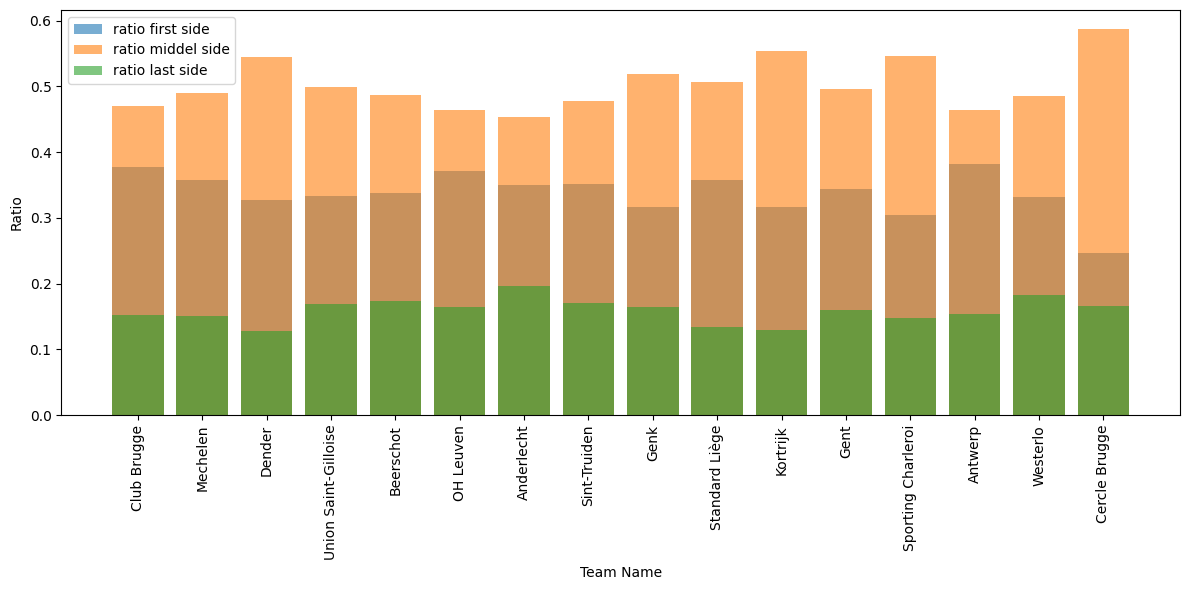

In [20]:
plt.figure(figsize=(12, 6))
plt.bar(df_merged_side['team_name'], df_merged_side['ratio first'], label='ratio first side', alpha=0.6)
plt.bar(df_merged_side['team_name'], df_merged_side['ratio middel'], label='ratio middel side', alpha=0.6)
plt.bar(df_merged_side['team_name'], df_merged_side['ratio last'], label='ratio last side', alpha=0.6)
plt.xlabel('Team Name')
plt.ylabel('Ratio')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()